In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Sci-kit Learn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load fastext predictions file
xlnet = pd.read_csv("../results/xlnet.csv", usecols=['id', "predicted_label"])

# Load Test data
df = pd.read_csv("../train_test_data/test_data.csv")

# Merge ft_lem with df
df = df.merge(xlnet)

# Rename predicted_label column
df.columns = ["xlnet_pred" if x=="predicted_label" else x for x in df.columns]

# Display
display(df.head())

,index,subreddit,date,author,id,clean_text,unique_clean_text,link_flair_text,num_comments,score,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,xlnet_pred
0,259423,CasualConversation,30/04/2020,TheTruthIsOutThere_x,gb1v57,watching tv show since free time decided watc...,watching tv show since free time decided watch...,:chat: Just Chatting,11.0,1,...,-0.230346,0.435463,-0.240147,-0.970172,-0.450281,-0.015213,-0.046762,0.125590,0.286794,0.0
1,116502,Anxiety,23/11/2020,CataleyaJackson,jzm4a5,feel like clawing skin idk feel like raking n...,feel like clawing skin idk raking nail pull st...,Needs A Hug/Support,2.0,1,...,-0.144513,0.128494,-0.516798,-0.515686,0.446294,-0.815760,0.466696,0.556928,-0.428114,1.0
2,372645,happy,31/01/2021,aoravecz87,l92a50,play adult rec league today first day back do...,play adult rec league today first day back dod...,NaN,3.0,1,...,-0.467907,0.128583,0.210970,-0.254567,-0.097350,0.040201,0.049906,-0.699199,-0.587128,0.0
3,289835,CasualConversation,12/11/2020,huesthrowaway,jsye0s,get dread single forever longest ever relatio...,get dread single forever longest ever relation...,:question: Questions,1.0,1,...,0.648418,0.430598,-0.480960,0.283681,-0.351802,-0.270069,-1.284344,-0.055346,0.113956,0.0
4,258003,mentalhealth,22/07/2021,throwawaythisthing_,opq81s,split meltdown anger attack dont even know poi...,split meltdown anger attack dont even know poi...,Need Support,10.0,1,...,-0.642569,0.021606,0.363371,0.052923,0.564225,0.241293,0.804391,-0.802330,0.210541,1.0


In [3]:
# Select all columns that are numerical
df_nums = df.select_dtypes(['number'])

# Drop NaNs
df_nums = df_nums.dropna()

# Filter out rows that were dropped
df = df[df["index"].isin(df_nums["index"])]

# Important columns to keep for final df
imp_cols = df[["index", "id", "subreddit", "clean_text"]]

# Set df to df_nums
df = df_nums

# Display
display(df.head())

,index,num_comments,score,post_length,word_count,norm_noun,norm_verb,norm_adj,norm_adv,compound_sent,...,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,xlnet_pred
0,259423,11.0,1,179,13,0.384615,0.307692,0.076923,0.153846,0.5106,...,-0.230346,0.435463,-0.240147,-0.970172,-0.450281,-0.015213,-0.046762,0.125590,0.286794,0.0
1,116502,2.0,1,873,57,0.368421,0.245614,0.192982,0.122807,-0.7675,...,-0.144513,0.128494,-0.516798,-0.515686,0.446294,-0.815760,0.466696,0.556928,-0.428114,1.0
2,372645,3.0,1,150,16,0.562500,0.000000,0.187500,0.250000,0.9186,...,-0.467907,0.128583,0.210970,-0.254567,-0.097350,0.040201,0.049906,-0.699199,-0.587128,0.0
3,289835,1.0,1,1020,69,0.362319,0.260870,0.217391,0.130435,-0.9814,...,0.648418,0.430598,-0.480960,0.283681,-0.351802,-0.270069,-1.284344,-0.055346,0.113956,0.0
4,258003,10.0,1,1830,136,0.441176,0.183824,0.227941,0.132353,-0.9933,...,-0.642569,0.021606,0.363371,0.052923,0.564225,0.241293,0.804391,-0.802330,0.210541,1.0


In [4]:
# Get 80% of data for training and 20% for testing,
# ensuring 50/50 depressive and non-depressive
dep = df[df["label"] == 1]
nd = df[df["label"] == 0]

print(len(dep.index))
print(len(nd.index))

# Make whicher is larger the same size as the smaller one
if(len(dep.index) > len(nd.index)):
    dep = dep.head(len(nd.index))
else:
    nd = nd.head(len(dep.index))

print(len(dep.index) == len(nd.index))

16635
16633
True


In [5]:
# Randomly select 80% for training and remainder for testing
dep_train = dep.sample(frac=0.8, random_state=0)
dep_test = dep[~dep["index"].isin(dep_train["index"])]
nd_train = nd.sample(frac=0.8, random_state=0)
nd_test = nd[~nd["index"].isin(dep_train["index"])]

# Build train-test data
X_train = pd.concat([dep_train, nd_train], ignore_index=True)
X_test = pd.concat([dep_test, nd_test], ignore_index=True)
y_train = X_train["label"].to_numpy()
y_test = X_test["label"].to_numpy()

# Keep test index
test_index = X_test["index"].to_numpy()

# Drop index and label column
X_train = X_train.drop(columns=["index", "label"])
X_test = X_test.drop(columns=["index", "label"])

# Keep column names
X_cols = X_train.columns

# Convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [6]:
# Initialize Model
rfc = RandomForestClassifier(n_estimators=400, random_state=1) 

# Train
rfc = rfc.fit(X_train, y_train)

# Predict
ypred = rfc.predict(X_test)

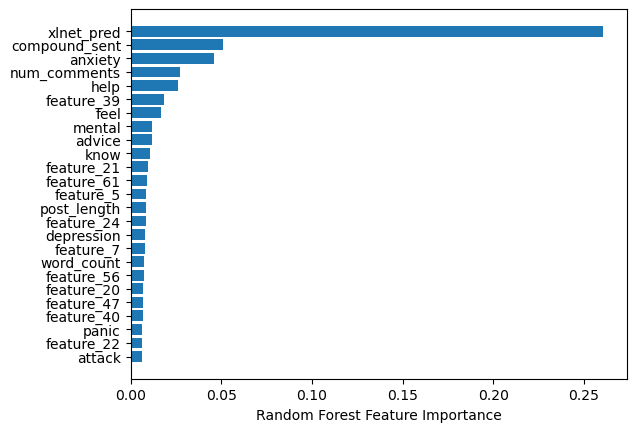

In [7]:
# Feature importance
sorted_idx = rfc.feature_importances_.argsort()
plt.barh([X_cols[i] for i in sorted_idx[-25:]], rfc.feature_importances_[sorted_idx[-25:]])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [8]:
# Scale input
rfc_scaled = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=400, random_state=1))

rfc_scaled = rfc_scaled.fit(X_train, y_train)

ypred_scaled = rfc_scaled.predict(X_test)

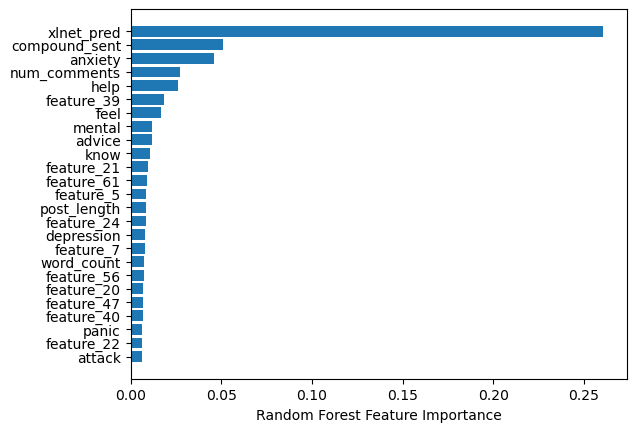

In [9]:
# Feature importance
sorted_idx = rfc_scaled[1].feature_importances_.argsort()
plt.barh([X_cols[i] for i in sorted_idx[-25:]], rfc.feature_importances_[sorted_idx[-25:]])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [10]:
# Evaluate Accuracy Score

# Convert y_test and ypred to type ints
y_test = y_test.astype(int)
ypred = ypred.astype(int)
ypred_scaled = ypred_scaled.astype(int)

# Print overall model average
print("The overall accuracy score is:", accuracy_score(y_test, ypred))
print("The overall precision score is:", precision_score(y_test, ypred))
print("The overall recall score is:", recall_score(y_test, ypred))
print("The overall f1 score for is:", f1_score(y_test, ypred))

print("\nScaled Results")
print("The overall accuracy score is:", accuracy_score(y_test, ypred_scaled))
print("The overall precision score is:", precision_score(y_test, ypred_scaled))
print("The overall recall score is:", recall_score(y_test, ypred_scaled))
print("The overall f1 score for is:", f1_score(y_test, ypred_scaled))

The overall accuracy score is: 0.9722222222222222
The overall precision score is: 0.9331883157240523
The overall recall score is: 0.9026149684400361
The overall f1 score for is: 0.9176470588235295

Scaled Results
The overall accuracy score is: 0.9722222222222222
The overall precision score is: 0.9331883157240523
The overall recall score is: 0.9026149684400361
The overall f1 score for is: 0.9176470588235295


In [11]:
# Merge back to original dataframe
results = np.array((test_index, y_test, ypred))

# Convert to dataframe
results = pd.DataFrame(np.transpose(results), columns=["index", "label", "predicted_label"])

# Merge with imp_cols
results = results.merge(imp_cols)

# Select and reorder columns
results = results[["id", "subreddit", "clean_text", "label", "predicted_label"]]

# Display
results

# Save to csv
results = results.to_csv("../results/rf_ensemble.csv", index=False)